# **Abandono de carrera por estudiantes mediante implementación de clasificación con PyTorch**

Asignatura: INF395 - Introducción a las Redes Neuronales y Deep Learning.

Integrantes:
* Bruno Morici - ROL: 202373555-8
* Juan Pablo Fuenzalida - ROL: 202373102-1
* Tutor: Alejandro Veloz


Usando el dataset de la UCL Machine Learning "Students' Dropout and Academic Success Dataset". Acceder mediante el siguiente link : https://archive.ics.uci.edu/dataset/697/predict+students+dropout+and+academic+success

## Importación e instalación de librerias necesarias

In [2]:
%pip install pandas
%pip install numpy
%pip install scikit-learn
%pip install matplotlib
%pip install seaborn
%pip install torch
%pip install tqdm
%pip install ucimlrepo

Note: you may need to restart the kernel to use updated packages.



[notice] A new release of pip is available: 25.2 -> 25.3
[notice] To update, run: python.exe -m pip install --upgrade pip


Note: you may need to restart the kernel to use updated packages.



[notice] A new release of pip is available: 25.2 -> 25.3
[notice] To update, run: python.exe -m pip install --upgrade pip


Note: you may need to restart the kernel to use updated packages.



[notice] A new release of pip is available: 25.2 -> 25.3
[notice] To update, run: python.exe -m pip install --upgrade pip


Note: you may need to restart the kernel to use updated packages.



[notice] A new release of pip is available: 25.2 -> 25.3
[notice] To update, run: python.exe -m pip install --upgrade pip


Note: you may need to restart the kernel to use updated packages.



[notice] A new release of pip is available: 25.2 -> 25.3
[notice] To update, run: python.exe -m pip install --upgrade pip


Note: you may need to restart the kernel to use updated packages.



[notice] A new release of pip is available: 25.2 -> 25.3
[notice] To update, run: python.exe -m pip install --upgrade pip


Note: you may need to restart the kernel to use updated packages.



[notice] A new release of pip is available: 25.2 -> 25.3
[notice] To update, run: python.exe -m pip install --upgrade pip


Note: you may need to restart the kernel to use updated packages.



[notice] A new release of pip is available: 25.2 -> 25.3
[notice] To update, run: python.exe -m pip install --upgrade pip


In [3]:
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
import seaborn as sns

import torch
import torch.nn as nn
import torch.optim as optim
from torch.utils.data import Dataset, DataLoader
from sklearn.decomposition import PCA
from sklearn.preprocessing import StandardScaler
from sklearn.model_selection import train_test_split
from sklearn.utils.class_weight import compute_class_weight
from sklearn.metrics import accuracy_score, classification_report, confusion_matrix, precision_score, recall_score, f1_score
from scipy.stats import zscore
from ucimlrepo import fetch_ucirepo
from tqdm import tqdm

# Configurar dispositivo
device = torch.device('cuda' if torch.cuda.is_available() else 'cpu')
print(f'Dispositivo utilizado: {device}') 

Dispositivo utilizado: cpu


## Limpieza y carga del Dataset

In [4]:
# Cargar el dataset (por ID)
dataset = fetch_ucirepo(id=697)

# Acceder a los datos como DataFrame de pandas
df = dataset.data.features
target = dataset.data.targets

# Unirlos si quieres un solo DataFrame
df = pd.concat([df, target], axis=1)

# Mostrar las primeras filas
df.head()

,Marital Status,Application mode,Application order,Course,Daytime/evening attendance,Previous qualification,Previous qualification (grade),Nacionality,Mother's qualification,Father's qualification,...,Curricular units 2nd sem (credited),Curricular units 2nd sem (enrolled),Curricular units 2nd sem (evaluations),Curricular units 2nd sem (approved),Curricular units 2nd sem (grade),Curricular units 2nd sem (without evaluations),Unemployment rate,Inflation rate,GDP,Target
0,1,17,5,171,1,1,122.0,1,19,12,...,0,0,0,0,0.000000,0,10.8,1.4,1.74,Dropout
1,1,15,1,9254,1,1,160.0,1,1,3,...,0,6,6,6,13.666667,0,13.9,-0.3,0.79,Graduate
2,1,1,5,9070,1,1,122.0,1,37,37,...,0,6,0,0,0.000000,0,10.8,1.4,1.74,Dropout
3,1,17,2,9773,1,1,122.0,1,38,37,...,0,6,10,5,12.400000,0,9.4,-0.8,-3.12,Graduate
4,2,39,1,8014,0,1,100.0,1,37,38,...,0,6,6,6,13.000000,0,13.9,-0.3,0.79,Graduate


**Información del dataset:**

In [5]:
df.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 4424 entries, 0 to 4423
Data columns (total 37 columns):
 #   Column                                          Non-Null Count  Dtype  
---  ------                                          --------------  -----  
 0   Marital Status                                  4424 non-null   int64  
 1   Application mode                                4424 non-null   int64  
 2   Application order                               4424 non-null   int64  
 3   Course                                          4424 non-null   int64  
 4   Daytime/evening attendance                      4424 non-null   int64  
 5   Previous qualification                          4424 non-null   int64  
 6   Previous qualification (grade)                  4424 non-null   float64
 7   Nacionality                                     4424 non-null   int64  
 8   Mother's qualification                          4424 non-null   int64  
 9   Father's qualification                   

**Revisando si existen valores nulos en el dataset:**

In [6]:
df.isna().sum()

Marital Status                                    0
Application mode                                  0
Application order                                 0
Course                                            0
Daytime/evening attendance                        0
Previous qualification                            0
Previous qualification (grade)                    0
Nacionality                                       0
Mother's qualification                            0
Father's qualification                            0
Mother's occupation                               0
Father's occupation                               0
Admission grade                                   0
Displaced                                         0
Educational special needs                         0
Debtor                                            0
Tuition fees up to date                           0
Gender                                            0
Scholarship holder                                0
Age at enrol

**Convertimos los nombres de las columnas a minúsculas para facilitar su manejo:**

In [7]:
df.columns = [col.replace(' ','_').replace("'s",'').replace('\t','').replace('/','_').replace('(','').replace(')','').lower() for col in df.columns]
df.columns

Index(['marital_status', 'application_mode', 'application_order', 'course',
       'daytime_evening_attendance', 'previous_qualification',
       'previous_qualification_grade', 'nacionality', 'mother_qualification',
       'father_qualification', 'mother_occupation', 'father_occupation',
       'admission_grade', 'displaced', 'educational_special_needs', 'debtor',
       'tuition_fees_up_to_date', 'gender', 'scholarship_holder',
       'age_at_enrollment', 'international',
       'curricular_units_1st_sem_credited',
       'curricular_units_1st_sem_enrolled',
       'curricular_units_1st_sem_evaluations',
       'curricular_units_1st_sem_approved', 'curricular_units_1st_sem_grade',
       'curricular_units_1st_sem_without_evaluations',
       'curricular_units_2nd_sem_credited',
       'curricular_units_2nd_sem_enrolled',
       'curricular_units_2nd_sem_evaluations',
       'curricular_units_2nd_sem_approved', 'curricular_units_2nd_sem_grade',
       'curricular_units_2nd_sem_without

Explicación para cada columna de la tabla:

| Columna                                        | Significado                                                                                                                 |
| ---------------------------------------------- | --------------------------------------------------------------------------------------------------------------------------- |
| `marital_status`                               | Estado civil del alumno/a al momento de la inscripción.                                                                     |
| `application_mode`                             | Modo de aplicación al curso (por ejemplo, presencial vs. en línea, u otra categoría).                                       |
| `application_order`                            | Orden de la solicitud de ingreso (por ejemplo, cuántas aplicaciones realizó antes, o prioridad de la solicitud).            |
| `course`                                       | Código o identificador del curso al que se inscribió el estudiante.                                                         |
| `daytime_evening_attendance`                   | Asistencia: diurna o vespertina (día vs. noche) para el curso.                                                              |
| `previous_qualification`                       | Tipo de cualificación/título anterior que tenía el estudiante antes de este nivel educativo.                                |
| `previous_qualification_grade`                 | Nota o calificación obtenida en la cualificación anterior.                                                                  |
| `nacionality`                                  | Nacionalidad del estudiante.                                                                                                |
| `mother_qualification`                         | Nivel de formación de la madre del estudiante.                                                                              |
| `father_qualification`                         | Nivel de formación del padre del estudiante.                                                                                |
| `mother_occupation`                            | Ocupación laboral de la madre del estudiante.                                                                               |
| `father_occupation`                            | Ocupación laboral del padre del estudiante.                                                                                 |
| `admission_grade`                              | Nota de admisión al curso/universidad del estudiante.                                                                       |
| `displaced`                                    | Si el estudiante es desplazado (por ejemplo, geográfica o socialmente) o no.                                                |
| `educational_special_needs`                    | Si el estudiante tiene necesidades educativas especiales.                                                                   |
| `debtor`                                       | Si el estudiante adeuda pagos (por ejemplo, matrícula u otros cargos) o no.                                                 |
| `tuition_fees_up_to_date`                      | Si las tasas de matrícula están al día o no.                                                                                |
| `gender`                                       | Género del estudiante.                                                                                                      |
| `scholarship_holder`                           | Si el estudiante tiene una beca o no.                                                                                       |
| `age_at_enrollment`                            | Edad del estudiante al momento de la inscripción.                                                                           |
| `international`                                | Si el estudiante es internacional (extranjero) o no.                                                                        |
| `curricular_units_1st_sem_credited`            | Unidades curriculares acreditadas en el primer semestre.                                                                    |
| `curricular_units_1st_sem_enrolled`            | Unidades curriculares en que se matriculó el estudiante en el primer semestre.                                              |
| `curricular_units_1st_sem_evaluations`         | Número de unidades curriculares que fueron evaluadas en el primer semestre.                                                 |
| `curricular_units_1st_sem_approved`            | Unidades curriculares aprobadas en el primer semestre.                                                                      |
| `curricular_units_1st_sem_grade`               | Nota promedio o de alguna unidad en el primer semestre (o quizá nota global del semestre).                                  |
| `curricular_units_1st_sem_without_evaluations` | Unidades curriculares del primer semestre sin evaluación (por ejemplo exentas u otro motivo).                               |
| `curricular_units_2nd_sem_credited`            | Unidades curriculares acreditadas en el segundo semestre.                                                                   |
| `curricular_units_2nd_sem_enrolled`            | Unidades curriculares en que se matriculó el estudiante en el segundo semestre.                                             |
| `curricular_units_2nd_sem_evaluations`         | Número de unidades curriculares que fueron evaluadas en el segundo semestre.                                                |
| `curricular_units_2nd_sem_approved`            | Unidades curriculares aprobadas en el segundo semestre.                                                                     |
| `curricular_units_2nd_sem_grade`               | Nota promedio o de alguna unidad en el segundo semestre (o nota global).                                                    |
| `curricular_units_2nd_sem_without_evaluations` | Unidades curriculares del segundo semestre sin evaluación.                                                                  |
| `unemployment_rate`                            | Tasa de desempleo correspondiente al contexto económico del estudiante (o región) en el momento.                            |
| `inflation_rate`                               | Tasa de inflación correspondiente al contexto económico del estudiante (o región) en el momento.                            |
| `gdp`                                          | Producto interno bruto (PIB) correspondiente al contexto económico del estudiante (o región) en el momento.                 |
| `target`                                       | Si el estudiante abandonó, se graduó o sigue cursando en la actualidad. |


**Análisis Exploratorio de datos**

In [8]:
df.describe()

,marital_status,application_mode,application_order,course,daytime_evening_attendance,previous_qualification,previous_qualification_grade,nacionality,mother_qualification,father_qualification,...,curricular_units_1st_sem_without_evaluations,curricular_units_2nd_sem_credited,curricular_units_2nd_sem_enrolled,curricular_units_2nd_sem_evaluations,curricular_units_2nd_sem_approved,curricular_units_2nd_sem_grade,curricular_units_2nd_sem_without_evaluations,unemployment_rate,inflation_rate,gdp
count,4424.000000,4424.000000,4424.000000,4424.000000,4424.000000,4424.000000,4424.000000,4424.000000,4424.000000,4424.000000,...,4424.000000,4424.000000,4424.000000,4424.000000,4424.000000,4424.000000,4424.000000,4424.000000,4424.000000,4424.000000
mean,1.178571,18.669078,1.727848,8856.642631,0.890823,4.577758,132.613314,1.873192,19.561935,22.275316,...,0.137658,0.541817,6.232143,8.063291,4.435805,10.230206,0.150316,11.566139,1.228029,0.001969
std,0.605747,17.484682,1.313793,2063.566416,0.311897,10.216592,13.188332,6.914514,15.603186,15.343108,...,0.690880,1.918546,2.195951,3.947951,3.014764,5.210808,0.753774,2.663850,1.382711,2.269935
min,1.000000,1.000000,0.000000,33.000000,0.000000,1.000000,95.000000,1.000000,1.000000,1.000000,...,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,7.600000,-0.800000,-4.060000
25%,1.000000,1.000000,1.000000,9085.000000,1.000000,1.000000,125.000000,1.000000,2.000000,3.000000,...,0.000000,0.000000,5.000000,6.000000,2.000000,10.750000,0.000000,9.400000,0.300000,-1.700000
50%,1.000000,17.000000,1.000000,9238.000000,1.000000,1.000000,133.100000,1.000000,19.000000,19.000000,...,0.000000,0.000000,6.000000,8.000000,5.000000,12.200000,0.000000,11.100000,1.400000,0.320000
75%,1.000000,39.000000,2.000000,9556.000000,1.000000,1.000000,140.000000,1.000000,37.000000,37.000000,...,0.000000,0.000000,7.000000,10.000000,6.000000,13.333333,0.000000,13.900000,2.600000,1.790000
max,6.000000,57.000000,9.000000,9991.000000,1.000000,43.000000,190.000000,109.000000,44.000000,44.000000,...,12.000000,19.000000,23.000000,33.000000,20.000000,18.571429,12.000000,16.200000,3.700000,3.510000


**Eliminamos Outliers con el método de Z-Score**

In [9]:
threshold = 3

z_scores = zscore(df.select_dtypes(include=[np.number]))
outliers = (np.abs(z_scores) > threshold).any(axis=1)
df_2 = df[~outliers].copy()

print(f"Se eliminaron { len(df) - len(df_2) } filas del dataset")
df_2

Se eliminaron 1343 filas del dataset


,marital_status,application_mode,application_order,course,daytime_evening_attendance,previous_qualification,previous_qualification_grade,nacionality,mother_qualification,father_qualification,...,curricular_units_2nd_sem_credited,curricular_units_2nd_sem_enrolled,curricular_units_2nd_sem_evaluations,curricular_units_2nd_sem_approved,curricular_units_2nd_sem_grade,curricular_units_2nd_sem_without_evaluations,unemployment_rate,inflation_rate,gdp,target
1,1,15,1,9254,1,1,160.0,1,1,3,...,0,6,6,6,13.666667,0,13.9,-0.3,0.79,Graduate
2,1,1,5,9070,1,1,122.0,1,37,37,...,0,6,0,0,0.000000,0,10.8,1.4,1.74,Dropout
3,1,17,2,9773,1,1,122.0,1,38,37,...,0,6,10,5,12.400000,0,9.4,-0.8,-3.12,Graduate
4,2,39,1,8014,0,1,100.0,1,37,38,...,0,6,6,6,13.000000,0,13.9,-0.3,0.79,Graduate
6,1,1,1,9500,1,1,142.0,1,19,38,...,0,8,8,8,14.345000,0,15.5,2.8,-4.06,Graduate
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
4410,1,1,1,9070,1,1,124.0,1,37,19,...,1,6,9,5,12.500000,0,10.8,1.4,1.74,Graduate
4412,1,43,1,9070,1,1,125.0,1,19,19,...,2,6,7,5,12.200000,0,13.9,-0.3,0.79,Enrolled
4414,1,1,1,9130,1,1,137.0,1,3,38,...,0,5,8,5,11.600000,0,9.4,-0.8,-3.12,Graduate
4417,1,1,1,9070,1,1,132.0,1,1,1,...,0,6,6,6,13.500000,0,16.2,0.3,-0.92,Graduate


**Verificamos que no haya desbalanceo de clases**

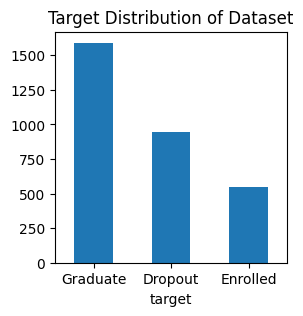

In [10]:
df_2['target'].value_counts()
df_2["target"].value_counts().plot(kind="bar", figsize=(3,3), title="Target Distribution of Dataset")
plt.xticks(rotation=0)
plt.show()

Como existe desbalanceo de clases, usaremos el método de **Balanceo Artificial por vía de Modificación de Función Objetivo** para las muestras que sean de las clases "Dropout" y "Enrolled"

## Separación del dataset en entrenamiento y testing

In [11]:
class_names, y = np.unique(df_2['target'], return_inverse=True)
print(y)
print(class_names)
X = df_2.drop('target', axis=1)

[2 0 2 ... 2 2 0]
['Dropout' 'Enrolled' 'Graduate']


**One Hot Encoding**

In [12]:
one_hot_cols = ['marital_status',
                'daytime_evening_attendance',
                'tuition_fees_up_to_date',
                'educational_special_needs',
                'displaced',
                'scholarship_holder',
                'gender',
                'debtor',
                'international',
                ]

for i in one_hot_cols:
    X[i] = X[i].apply(lambda x: float(x))
    X[i] = X[i].apply(lambda x: int(x))

for i in one_hot_cols:
    dum = pd.get_dummies(X[i], prefix=i)
    X.drop([i], axis=1, inplace=True)
    X = pd.concat([X, dum], axis=1)

**Dividimos el Dataset en entrenamiento y testing**

In [13]:
X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=0.2, random_state=1)
X_train_corr = X_train.copy()
X_train_corr['target'] = y_train

**Mapa de correlación de la variable target en base a las diferentes columnas de el Dataset**

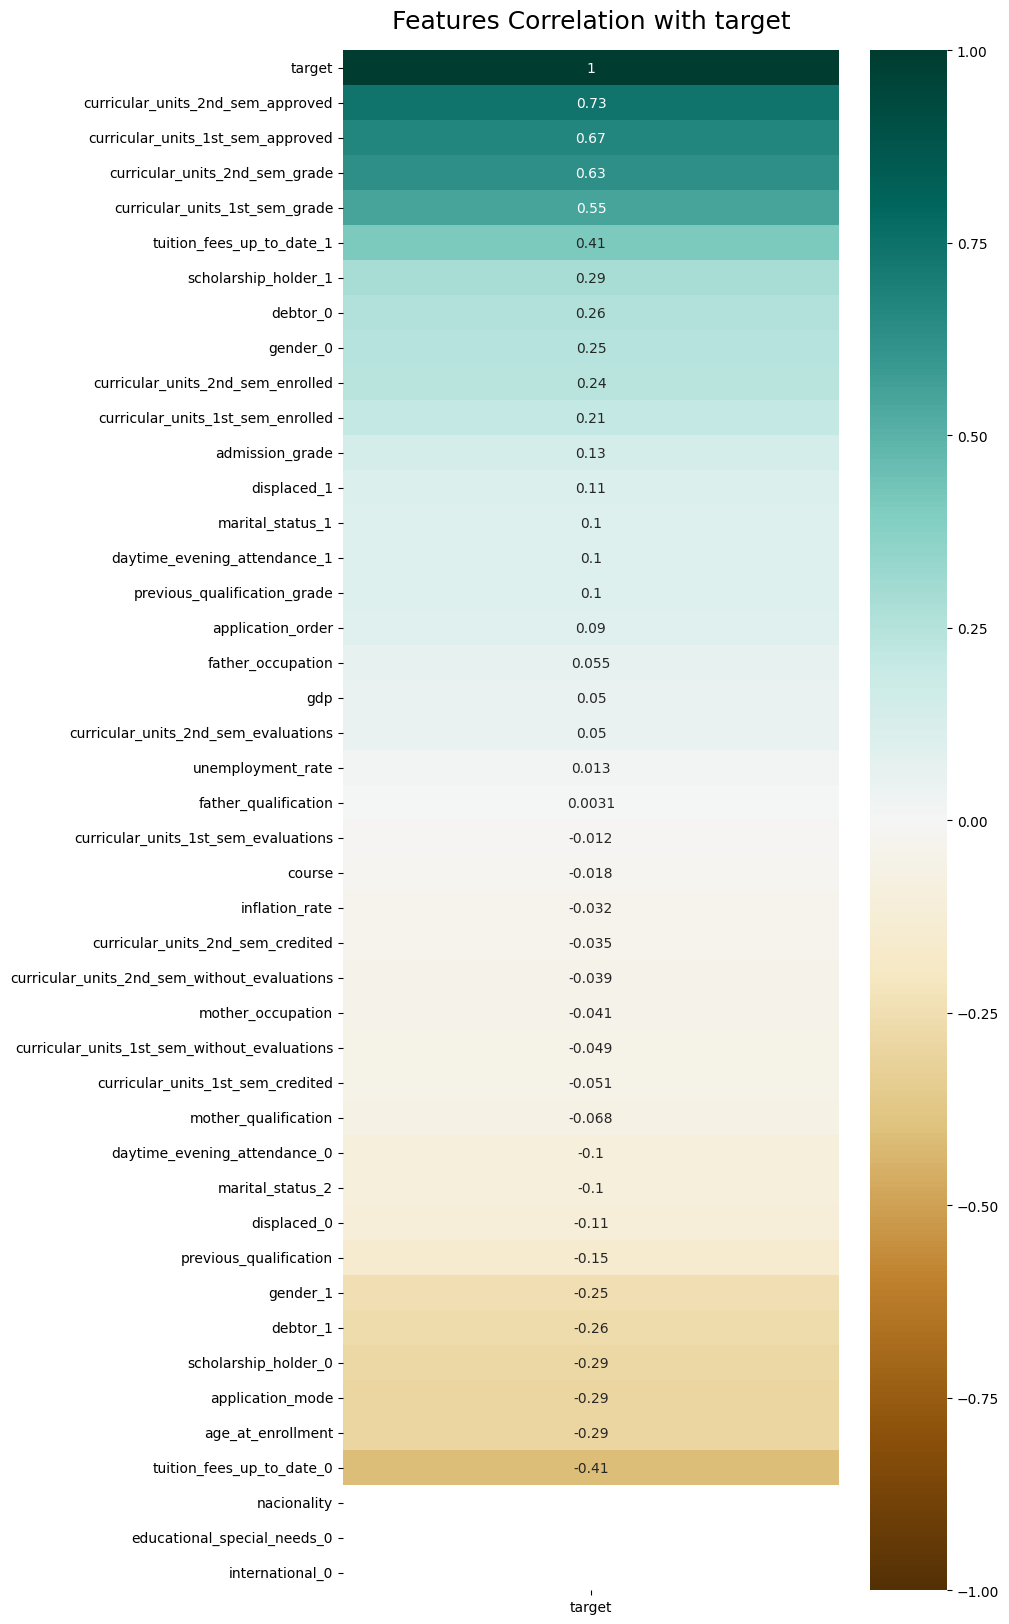

In [14]:
plt.figure(figsize=(8, 20))
heatmap = sns.heatmap(X_train_corr.corr()[['target']].sort_values(by='target', ascending=False), vmin=-1, vmax=1, annot=True, cmap='BrBG')
heatmap.set_title('Features Correlation with target', fontdict={'fontsize':18}, pad=16);

**Seleccionamos las features que deseamos analizar.**

In [15]:
features_list = ['curricular_units_2nd_sem_approved',
                 'curricular_units_1st_sem_approved',
                 'curricular_units_2nd_sem_grade',
                 'curricular_units_1st_sem_grade',
                 'tuition_fees_up_to_date_1',
                 'scholarship_holder_1',
                 'debtor_0',
                 'gender_0',
                 'curricular_units_2nd_sem_enrolled',
                 'curricular_units_1st_sem_enrolled',
                 'tuition_fees_up_to_date_0',
                 'age_at_enrollment',
                 'application_mode',
                 'scholarship_holder_0',
                 'debtor_1',
                 'gender_1']

**Recortamos el entrenamiento y testing a esas features**

In [16]:
X_train_fs = X_train[features_list]
X_test_fs = X_test[features_list]

**Normalizamos de forma estándar los datos, con el fin de no darle más relevancia al número por su tamaño en sí, si no que por su impacto respecto a los otros datos**

In [17]:
scaler = StandardScaler()
scaler.fit(X_train_fs)

X_train_sc = scaler.transform(X_train_fs)
X_test_sc = scaler.transform(X_test_fs)
X_train_sc = pd.DataFrame(X_train_sc, columns=X_train_fs.columns)
X_test_sc = pd.DataFrame(X_test_sc, columns=X_test_fs.columns)

**Aplicamos PCA para disminuir la complejidad del modelo**

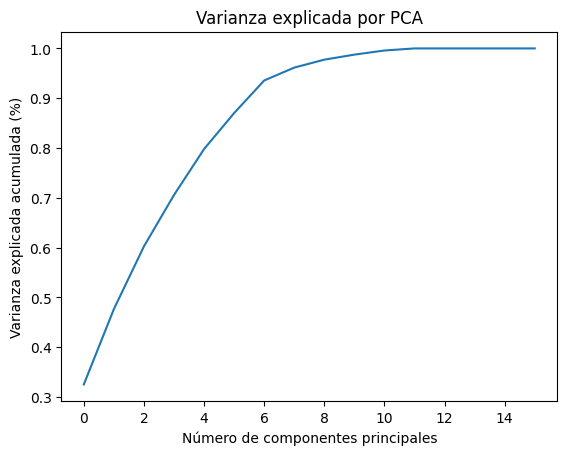

In [18]:
# Ajustar el modelo PCA a los datos de entrenamiento ya escalados
pca = PCA().fit(X_train_sc)

# Crear una figura y graficar la varianza acumulada explicada por los componentes principales
plt.figure()
plt.plot(np.cumsum(pca.explained_variance_ratio_))
plt.xlabel('Número de componentes principales')
plt.ylabel('Varianza explicada acumulada (%)')
plt.title('Varianza explicada por PCA')
plt.show()

In [19]:
num_pca = 16
pca = PCA(n_components=num_pca, whiten=True).fit(X_train_sc)
X_train_pc = pca.transform(X_train_sc)
X_test_pc = pca.transform(X_test_sc)

**Balanceamos mediante modificación de la Función Objetivo, haciendo variar los pesos**

In [20]:
classes = np.unique(y_train)
weights = compute_class_weight(class_weight='balanced', classes=classes, y=y_train)
class_weights = dict(zip(classes, weights))
class_weights

{np.int64(0): np.float64(1.0893015030946065),
 np.int64(1): np.float64(1.837434750186428),
 np.int64(2): np.float64(0.6503035101609923)}

## Modelo de predicción

**Configuración de Hiperparámetros**

Definimos los hiperparámetros que definirán la creación y modelamiento de nuestro modelo de predicción, siendo estas:

1. input_size que define el tamaño de la primera capa de la red neuronal.

2. num_layers especifica el número de capas ocultas en la arquitectura de la red neuronal.

3. hidden_sizes define el número de neuronas de cada capa oculta del modelo.

4. dropout_rates especifica la tasa de dropout para cada capa oculta, siendo esta una técnica de regularización que desactiva aleatoriamente un porcentaje de neuronas durante el entrenamiento para prevenir el sobreajuste.

5. activation define la función de activación utilizada en las capas ocultas.

6. learning_rate controla el tamaño de los pasos que toma el optimizador durante el entrenamiento.

7. batch_size define el número de muestras que se procesan antes de actualizar los pesos del modelo.

8. num_epochs especifica el número máximo de iteraciones completas sobre todo el conjunto de entrenamiento.

9. weight_decay implementa regularización L2, que penaliza los pesos grandes del modelo, previniendo el sobreajuste.

10. patience define el número de épocas que el modelo puede entrenar sin mejorar antes de activar el early stopping.


In [21]:
HYPERPARAMETERS = {
    'input_size': 16, 
    'num_layers': 4, 
    'hidden_sizes': [128, 64, 32, 16], 
    'dropout_rates': [0.4, 0.3, 0.2, 0.1],  
    'activation': 'relu', 
    'learning_rate': 0.0005, 
    'batch_size': 32,  
    'num_epochs': 200,  
    'weight_decay': 0.0005, 
    'patience': 25, 
}

**Resumen del Modelo**

Nuestro modelo de prediccion es una red neuronal feedforward diseñada para clasificar estudiantes en tres categorías: Dropout, Enrolled y Graduate. 

Utiliza dropout progresivo para regularización efectiva, ademas implementa función de activación ReLU para introducir no-linealidad. Aplica Softmax en la salida para generar probabilidades de pertenencia a cada clase, para finalmente producir una distribución de probabilidades sobre las tres clases posibles.


In [22]:
class StudentDropoutModel(nn.Module):
    def __init__(self, input_size, hidden_sizes, dropout_rates, activation='relu', num_classes=3):
        super(StudentDropoutModel, self).__init__()
        
        self.layers = nn.ModuleList()
        self.dropouts = nn.ModuleList()
        
        if activation == 'relu':
            self.activation = nn.ReLU()
        elif activation == 'tanh':
            self.activation = nn.Tanh()
        elif activation == 'sigmoid':
            self.activation = nn.Sigmoid()
        else:
            self.activation = nn.ReLU()
        
        prev_size = input_size
        for hidden_size, dropout_rate in zip(hidden_sizes, dropout_rates):
            self.layers.append(nn.Linear(prev_size, hidden_size))
            self.dropouts.append(nn.Dropout(dropout_rate))
            prev_size = hidden_size
        
        self.output = nn.Linear(prev_size, num_classes)
        self.softmax = nn.Softmax(dim=1)
    
    def forward(self, x):
        for layer, dropout in zip(self.layers, self.dropouts):
            x = layer(x)
            x = self.activation(x)
            x = dropout(x)
        
        x = self.output(x)
        return self.softmax(x)
    
    def predict_class(self, x):
        with torch.no_grad():
            probs = self.forward(x)
            return torch.argmax(probs, dim=1)

model = StudentDropoutModel(
    input_size=HYPERPARAMETERS['input_size'],
    hidden_sizes=HYPERPARAMETERS['hidden_sizes'],
    dropout_rates=HYPERPARAMETERS['dropout_rates'],
    activation=HYPERPARAMETERS['activation'],
    num_classes=3
).to(device)

print(f"\nArquitectura del modelo:")
print(model)
print(f"\nNúmero total de parámetros: {sum(p.numel() for p in model.parameters()):,}")


Arquitectura del modelo:
StudentDropoutModel(
  (layers): ModuleList(
    (0): Linear(in_features=16, out_features=128, bias=True)
    (1): Linear(in_features=128, out_features=64, bias=True)
    (2): Linear(in_features=64, out_features=32, bias=True)
    (3): Linear(in_features=32, out_features=16, bias=True)
  )
  (dropouts): ModuleList(
    (0): Dropout(p=0.4, inplace=False)
    (1): Dropout(p=0.3, inplace=False)
    (2): Dropout(p=0.2, inplace=False)
    (3): Dropout(p=0.1, inplace=False)
  )
  (activation): ReLU()
  (output): Linear(in_features=16, out_features=3, bias=True)
  (softmax): Softmax(dim=1)
)

Número total de parámetros: 13,091


**Dataset y DataLoader para PyTorch**

Preparamos los datasets apropiados para el modelo para el set de entrenamiento y testeo, y sus respectivo dataloaders.

In [23]:
# Clase Dataset personalizada
class StudentDataset(Dataset):
    def __init__(self, features, labels):
        self.features = torch.FloatTensor(features)
        self.labels = torch.LongTensor(labels)
    
    def __len__(self):
        return len(self.labels)
    
    def __getitem__(self, idx):
        return self.features[idx], self.labels[idx]

# Crear datasets
train_dataset = StudentDataset(X_train_pc, y_train)
test_dataset = StudentDataset(X_test_pc, y_test)

# Crear DataLoaders
train_loader = DataLoader(
    train_dataset, 
    batch_size=HYPERPARAMETERS['batch_size'], 
    shuffle=True
)
test_loader = DataLoader(
    test_dataset, 
    batch_size=HYPERPARAMETERS['batch_size'], 
    shuffle=False
)

print(f"Tamaño del conjunto de entrenamiento: {len(train_dataset)}")
print(f"Tamaño del conjunto de prueba: {len(test_dataset)}")

Tamaño del conjunto de entrenamiento: 2464
Tamaño del conjunto de prueba: 617


**Entrenamiento del modelo**

El proceso de entrenamiento del modelo implementa balanceo de clases, utilizando pesos de clases calculados para manejar el desbalance en el dataset, la función de pérdida CrossEntropyLoss con pesos de clases para penalizar más los errores en clases desbalanceadas. Utilizamos el optimizador Adam para prevenir sobreajuste y un Learning Rate Scheduler ReduceLROnPlateau que reduce el learning rate automáticamente cuando la pérdida de validación deja de mejorar, finalmente el Early Stopping, que detiene el entrenamiento si no hay mejora en la pérdida de validación por 25 épocas consecutivas, restaurando automáticamente el mejor modelo encontrado.

Podemos describir el proceso de entrenamiento en tres fases:
1. Fase de entrenamiento: 
   - El modelo procesa batches de datos de entrenamiento
   - Calcula la pérdida mediante forward pass
   - Actualiza los pesos mediante backward pass y optimizador
   - Calcula precisión y pérdida promedio

2. Fase de validación:
   - Evalúa el modelo en el conjunto de validación sin actualizar pesos
   - Calcula métricas de validación
   - Actualiza el learning rate scheduler basado en la pérdida de validación

3. Monitoreo y control:
   - Guarda el mejor modelo basado en la pérdida de validación
   - Implementa early stopping para prevenir sobreajuste
   - Muestra métricas en tiempo real mediante barras de progreso

In [24]:
class_weights_tensor = torch.FloatTensor([class_weights[i] for i in sorted(class_weights.keys())]).to(device)
criterion = nn.CrossEntropyLoss(weight=class_weights_tensor)

optimizer = optim.Adam(
    model.parameters(), 
    lr=HYPERPARAMETERS['learning_rate'],
    weight_decay=HYPERPARAMETERS['weight_decay']
)

scheduler = optim.lr_scheduler.ReduceLROnPlateau(
    optimizer, mode='min', factor=0.5, patience=10
)

train_losses = []
train_accuracies = []
val_losses = []
val_accuracies = []
best_val_loss = float('inf')
best_val_acc = 0.0
patience_counter = 0
best_model_state = None
best_epoch = 0

print("Iniciando entrenamiento...\n")
epoch_pbar = tqdm(range(HYPERPARAMETERS['num_epochs']), desc='Entrenamiento', unit='epoch')

for epoch in epoch_pbar:
    model.train()
    train_loss = 0.0
    train_correct = 0
    train_total = 0
    train_pbar = tqdm(train_loader, desc=f'Epoch {epoch+1}/{HYPERPARAMETERS["num_epochs"]} [Train]', leave=False, unit='batch')
    for features, labels in train_pbar:
        features, labels = features.to(device), labels.to(device)
        optimizer.zero_grad()
        outputs = model(features)
        loss = criterion(outputs, labels)
        loss.backward()
        optimizer.step()
        train_loss += loss.item()
        _, predicted = torch.max(outputs.data, 1)
        train_total += labels.size(0)
        train_correct += (predicted == labels).sum().item()
        train_acc_batch = 100 * train_correct / train_total
        train_pbar.set_postfix({
            'Loss': f'{loss.item():.4f}',
            'Acc': f'{train_acc_batch:.2f}%'
        })
    
    train_loss /= len(train_loader)
    train_acc = 100 * train_correct / train_total
    train_losses.append(train_loss)
    train_accuracies.append(train_acc)
    model.eval()
    val_loss = 0.0
    val_correct = 0
    val_total = 0

    val_pbar = tqdm(test_loader, desc=f'Epoch {epoch+1}/{HYPERPARAMETERS["num_epochs"]} [Val]', 
                    leave=False, unit='batch')
    
    with torch.no_grad():
        for features, labels in val_pbar:
            features, labels = features.to(device), labels.to(device)
            outputs = model(features)
            loss = criterion(outputs, labels)
            
            val_loss += loss.item()
            _, predicted = torch.max(outputs.data, 1)
            val_total += labels.size(0)
            val_correct += (predicted == labels).sum().item()
            
            val_acc_batch = 100 * val_correct / val_total
            val_pbar.set_postfix({
                'Loss': f'{loss.item():.4f}',
                'Acc': f'{val_acc_batch:.2f}%'
            })
    
    val_loss /= len(test_loader)
    val_acc = 100 * val_correct / val_total
    val_losses.append(val_loss)
    val_accuracies.append(val_acc)

    epoch_pbar.set_postfix({
        'Train Loss': f'{train_loss:.4f}',
        'Train Acc': f'{train_acc:.2f}%',
        'Val Loss': f'{val_loss:.4f}',
        'Val Acc': f'{val_acc:.2f}%',
        'Best Val Acc': f'{best_val_acc:.2f}%',
        'Patience': f'{patience_counter}/{HYPERPARAMETERS["patience"]}'
    })
    
    if val_loss < best_val_loss:
        improvement = best_val_loss - val_loss
        best_val_loss = val_loss
        best_val_acc = val_acc
        patience_counter = 0
        best_model_state = model.state_dict().copy()
        best_epoch = epoch + 1
        epoch_pbar.write(f'✓ Mejora en epoch {epoch+1}: Val Loss mejoró de {best_val_loss + improvement:.4f} a {best_val_loss:.4f} (Val Acc: {val_acc:.2f}%)')
    else:
        patience_counter += 1
        if patience_counter >= HYPERPARAMETERS['patience']:
            epoch_pbar.write(f'\n⚠ Early stopping activado en epoch {epoch+1}')
            epoch_pbar.write(f'   Mejor modelo encontrado en epoch {best_epoch}')
            epoch_pbar.write(f'   Mejor Val Loss: {best_val_loss:.4f}')
            epoch_pbar.write(f'   Mejor Val Acc: {best_val_acc:.2f}%')
            epoch_pbar.write(f'   Razón: No hubo mejora en Val Loss por {HYPERPARAMETERS["patience"]} épocas consecutivas')
            epoch_pbar.write(f'   El modelo se detuvo para prevenir sobreajuste (overfitting)')
            model.load_state_dict(best_model_state)
            break

epoch_pbar.close()
print("\n" + "="*60)
print("ENTRENAMIENTO COMPLETADO")
print("="*60)
print(f"Mejor modelo guardado de epoch {best_epoch}")
print(f"Mejor Val Loss: {best_val_loss:.4f}")
print(f"Mejor Val Acc: {best_val_acc:.2f}%")
print(f"Total de épocas entrenadas: {len(train_losses)}")


Iniciando entrenamiento...



Entrenamiento:   0%|          | 1/200 [00:00<01:20,  2.46epoch/s, Train Loss=1.0851, Train Acc=57.35%, Val Loss=1.0465, Val Acc=51.70%, Best Val Acc=0.00%, Patience=0/25]

✓ Mejora en epoch 1: Val Loss mejoró de inf a 1.0465 (Val Acc: 51.70%)


Entrenamiento:   1%|          | 2/200 [00:00<01:09,  2.85epoch/s, Train Loss=1.0210, Train Acc=60.63%, Val Loss=0.9676, Val Acc=75.85%, Best Val Acc=51.70%, Patience=0/25]

✓ Mejora en epoch 2: Val Loss mejoró de 1.0465 a 0.9676 (Val Acc: 75.85%)


Entrenamiento:   2%|▏         | 3/200 [00:01<01:05,  3.01epoch/s, Train Loss=0.9620, Train Acc=72.56%, Val Loss=0.9126, Val Acc=76.82%, Best Val Acc=75.85%, Patience=0/25]

✓ Mejora en epoch 3: Val Loss mejoró de 0.9676 a 0.9126 (Val Acc: 76.82%)


Entrenamiento:   2%|▏         | 4/200 [00:01<01:04,  3.02epoch/s, Train Loss=0.9110, Train Acc=74.92%, Val Loss=0.8611, Val Acc=77.96%, Best Val Acc=76.82%, Patience=0/25]

✓ Mejora en epoch 4: Val Loss mejoró de 0.9126 a 0.8611 (Val Acc: 77.96%)


Entrenamiento:   2%|▎         | 5/200 [00:01<01:02,  3.10epoch/s, Train Loss=0.8894, Train Acc=73.54%, Val Loss=0.8603, Val Acc=76.99%, Best Val Acc=77.96%, Patience=0/25]

✓ Mejora en epoch 5: Val Loss mejoró de 0.8611 a 0.8603 (Val Acc: 76.99%)


Entrenamiento:   3%|▎         | 6/200 [00:02<01:04,  3.03epoch/s, Train Loss=0.8811, Train Acc=74.11%, Val Loss=0.8438, Val Acc=77.15%, Best Val Acc=76.99%, Patience=0/25]

✓ Mejora en epoch 6: Val Loss mejoró de 0.8603 a 0.8438 (Val Acc: 77.15%)


Entrenamiento:   4%|▎         | 7/200 [00:02<01:02,  3.10epoch/s, Train Loss=0.8704, Train Acc=74.03%, Val Loss=0.8319, Val Acc=76.82%, Best Val Acc=77.15%, Patience=0/25]

✓ Mejora en epoch 7: Val Loss mejoró de 0.8438 a 0.8319 (Val Acc: 76.82%)


Entrenamiento:   4%|▍         | 8/200 [00:02<01:01,  3.14epoch/s, Train Loss=0.8556, Train Acc=74.68%, Val Loss=0.8260, Val Acc=77.63%, Best Val Acc=76.82%, Patience=0/25]

✓ Mejora en epoch 8: Val Loss mejoró de 0.8319 a 0.8260 (Val Acc: 77.63%)


Entrenamiento:   4%|▍         | 9/200 [00:02<01:01,  3.12epoch/s, Train Loss=0.8596, Train Acc=73.50%, Val Loss=0.8225, Val Acc=77.80%, Best Val Acc=77.63%, Patience=0/25]

✓ Mejora en epoch 9: Val Loss mejoró de 0.8260 a 0.8225 (Val Acc: 77.80%)


Entrenamiento:   6%|▌         | 11/200 [00:03<01:00,  3.10epoch/s, Train Loss=0.8522, Train Acc=74.80%, Val Loss=0.8162, Val Acc=77.96%, Best Val Acc=77.80%, Patience=1/25]

✓ Mejora en epoch 11: Val Loss mejoró de 0.8225 a 0.8162 (Val Acc: 77.96%)


Entrenamiento:   6%|▋         | 13/200 [00:04<00:59,  3.16epoch/s, Train Loss=0.8475, Train Acc=74.51%, Val Loss=0.8161, Val Acc=77.47%, Best Val Acc=77.96%, Patience=1/25]

✓ Mejora en epoch 13: Val Loss mejoró de 0.8162 a 0.8161 (Val Acc: 77.47%)


Entrenamiento:   7%|▋         | 14/200 [00:04<00:58,  3.17epoch/s, Train Loss=0.8377, Train Acc=75.49%, Val Loss=0.8125, Val Acc=76.34%, Best Val Acc=77.47%, Patience=0/25]

✓ Mejora en epoch 14: Val Loss mejoró de 0.8161 a 0.8125 (Val Acc: 76.34%)


Entrenamiento:   9%|▉         | 18/200 [00:05<01:02,  2.90epoch/s, Train Loss=0.8386, Train Acc=75.41%, Val Loss=0.8096, Val Acc=78.61%, Best Val Acc=76.34%, Patience=3/25]

✓ Mejora en epoch 18: Val Loss mejoró de 0.8125 a 0.8096 (Val Acc: 78.61%)


Entrenamiento:  14%|█▎        | 27/200 [00:08<00:55,  3.11epoch/s, Train Loss=0.8269, Train Acc=75.12%, Val Loss=0.8087, Val Acc=77.63%, Best Val Acc=78.61%, Patience=8/25]

✓ Mejora en epoch 27: Val Loss mejoró de 0.8096 a 0.8087 (Val Acc: 77.63%)


Entrenamiento:  18%|█▊        | 36/200 [00:11<00:48,  3.41epoch/s, Train Loss=0.8104, Train Acc=76.06%, Val Loss=0.8086, Val Acc=76.99%, Best Val Acc=77.63%, Patience=8/25]

✓ Mejora en epoch 36: Val Loss mejoró de 0.8087 a 0.8086 (Val Acc: 76.99%)


Entrenamiento:  19%|█▉        | 38/200 [00:12<00:45,  3.53epoch/s, Train Loss=0.8161, Train Acc=76.18%, Val Loss=0.8085, Val Acc=77.47%, Best Val Acc=76.99%, Patience=1/25]

✓ Mejora en epoch 38: Val Loss mejoró de 0.8086 a 0.8085 (Val Acc: 77.47%)


Entrenamiento:  21%|██        | 42/200 [00:13<00:47,  3.31epoch/s, Train Loss=0.8107, Train Acc=76.99%, Val Loss=0.8059, Val Acc=76.66%, Best Val Acc=77.47%, Patience=3/25]

✓ Mejora en epoch 42: Val Loss mejoró de 0.8085 a 0.8059 (Val Acc: 76.66%)


Entrenamiento:  32%|███▎      | 65/200 [00:20<00:42,  3.17epoch/s, Train Loss=0.7980, Train Acc=78.33%, Val Loss=0.8058, Val Acc=76.66%, Best Val Acc=76.66%, Patience=22/25]

✓ Mejora en epoch 65: Val Loss mejoró de 0.8059 a 0.8058 (Val Acc: 76.66%)


Entrenamiento:  38%|███▊      | 76/200 [00:23<00:36,  3.41epoch/s, Train Loss=0.8173, Train Acc=76.66%, Val Loss=0.8030, Val Acc=76.66%, Best Val Acc=76.66%, Patience=10/25]

✓ Mejora en epoch 76: Val Loss mejoró de 0.8058 a 0.8030 (Val Acc: 76.66%)


Entrenamiento:  46%|████▋     | 93/200 [00:28<00:29,  3.61epoch/s, Train Loss=0.7936, Train Acc=78.33%, Val Loss=0.8000, Val Acc=77.47%, Best Val Acc=76.66%, Patience=16/25]

✓ Mejora en epoch 93: Val Loss mejoró de 0.8030 a 0.8000 (Val Acc: 77.47%)


Entrenamiento:  50%|████▉     | 99/200 [00:29<00:27,  3.64epoch/s, Train Loss=0.7943, Train Acc=78.21%, Val Loss=0.7993, Val Acc=77.47%, Best Val Acc=77.47%, Patience=5/25] 

✓ Mejora en epoch 99: Val Loss mejoró de 0.8000 a 0.7993 (Val Acc: 77.47%)


Entrenamiento:  62%|██████▏   | 123/200 [00:36<00:23,  3.34epoch/s, Train Loss=0.7953, Train Acc=77.60%, Val Loss=0.8041, Val Acc=77.15%, Best Val Acc=77.47%, Patience=24/25]


⚠ Early stopping activado en epoch 124
   Mejor modelo encontrado en epoch 99
   Mejor Val Loss: 0.7993
   Mejor Val Acc: 77.47%
   Razón: No hubo mejora en Val Loss por 25 épocas consecutivas
   El modelo se detuvo para prevenir sobreajuste (overfitting)

ENTRENAMIENTO COMPLETADO
Mejor modelo guardado de epoch 99
Mejor Val Loss: 0.7993
Mejor Val Acc: 77.47%
Total de épocas entrenadas: 124


**Gráfico de pérdida y precision por épocas**

Una vez entrenado el modelo generamos los siguientes graficos que describen la evolucion tanto de la pérdida, como de la precision a medida que crecen los epochs, comparandolos con el dataset de testeo/validacion.

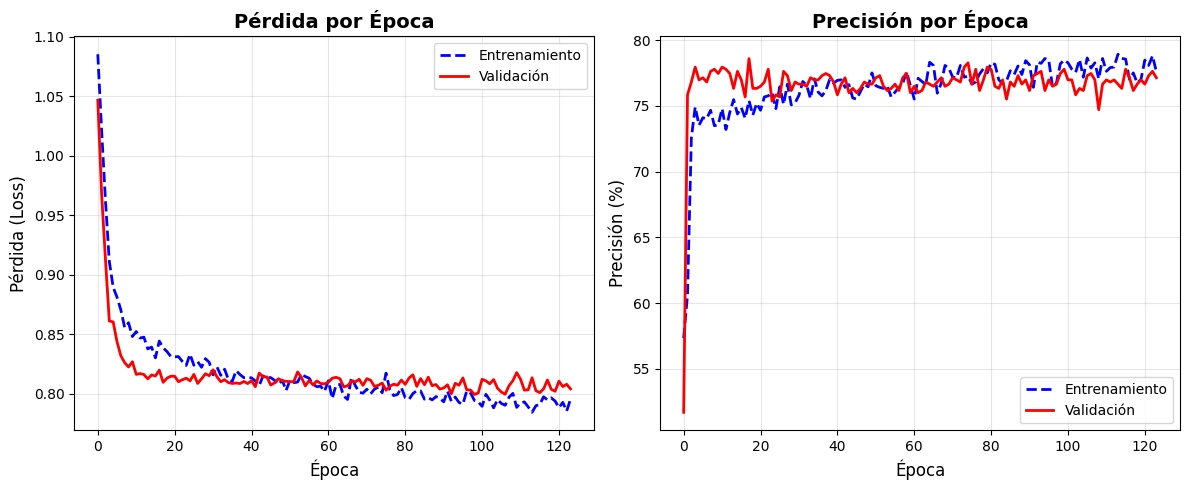

Mejor pérdida de validación: 0.7993
Mejor precisión de validación: 78.61%


In [25]:
plt.figure(figsize=(12, 5))

plt.subplot(1, 2, 1)
plt.plot(train_losses, 'b--', label='Entrenamiento', linewidth=2)
plt.plot(val_losses, 'r-', label='Validación', linewidth=2)
plt.xlabel('Época', fontsize=12)
plt.ylabel('Pérdida (Loss)', fontsize=12)
plt.title('Pérdida por Época', fontsize=14, fontweight='bold')
plt.legend(fontsize=10)
plt.grid(True, alpha=0.3)

plt.subplot(1, 2, 2)
plt.plot(train_accuracies, 'b--', label='Entrenamiento', linewidth=2)
plt.plot(val_accuracies, 'r-', label='Validación', linewidth=2)
plt.xlabel('Época', fontsize=12)
plt.ylabel('Precisión (%)', fontsize=12)
plt.title('Precisión por Época', fontsize=14, fontweight='bold')
plt.legend(fontsize=10)
plt.grid(True, alpha=0.3)

plt.tight_layout()
plt.show()

print(f"Mejor pérdida de validación: {min(val_losses):.4f}")
print(f"Mejor precisión de validación: {max(val_accuracies):.2f}%")


**Evaluación final y métricas**

Se muestran los resultados finales para los parametros del modelo, consecuencia de su entrenamiento.

In [26]:
model.eval()
all_predictions = []
all_labels = []

with torch.no_grad():
    for features, labels in test_loader:
        features = features.to(device)
        outputs = model(features)
        _, predicted = torch.max(outputs, 1)
        all_predictions.extend(predicted.cpu().numpy())
        all_labels.extend(labels.numpy())

y_pred = np.array(all_predictions)
y_true = np.array(all_labels)
accuracy = accuracy_score(y_true, y_pred)
precision = precision_score(y_true, y_pred, average='weighted', zero_division=0)
recall = recall_score(y_true, y_pred, average='weighted', zero_division=0)
f1 = f1_score(y_true, y_pred, average='weighted', zero_division=0)

print("=" * 60)
print("RESULTADOS FINALES DEL MODELO")
print("=" * 60)
print(f"\nPrecisión (Accuracy): {accuracy:.4f} ({accuracy*100:.2f}%)")
print(f"Precisión (Precision - Weighted): {precision:.4f}")
print(f"Recall (Weighted): {recall:.4f}")
print(f"F1-Score (Weighted): {f1:.4f}")
print("\n" + "=" * 60)
print("\nReporte de Clasificación Detallado:")
print("=" * 60)
print(classification_report(y_true, y_pred, target_names=class_names, zero_division=0))


RESULTADOS FINALES DEL MODELO

Precisión (Accuracy): 0.7715 (77.15%)
Precisión (Precision - Weighted): 0.8082
Recall (Weighted): 0.7715
F1-Score (Weighted): 0.7825


Reporte de Clasificación Detallado:
              precision    recall  f1-score   support

     Dropout       0.90      0.70      0.79       190
    Enrolled       0.43      0.64      0.51        99
    Graduate       0.87      0.85      0.86       328

    accuracy                           0.77       617
   macro avg       0.73      0.73      0.72       617
weighted avg       0.81      0.77      0.78       617



**Matriz de Confusión**

Generamos la matriz de confusión, que permite visualizar cómo se comporta el modelo al re-clasificar cada una de las clases durante el proceso de evaluación o validación, para visualizar si efectivamente las clasifica deacuerdo a su etiqueta real.

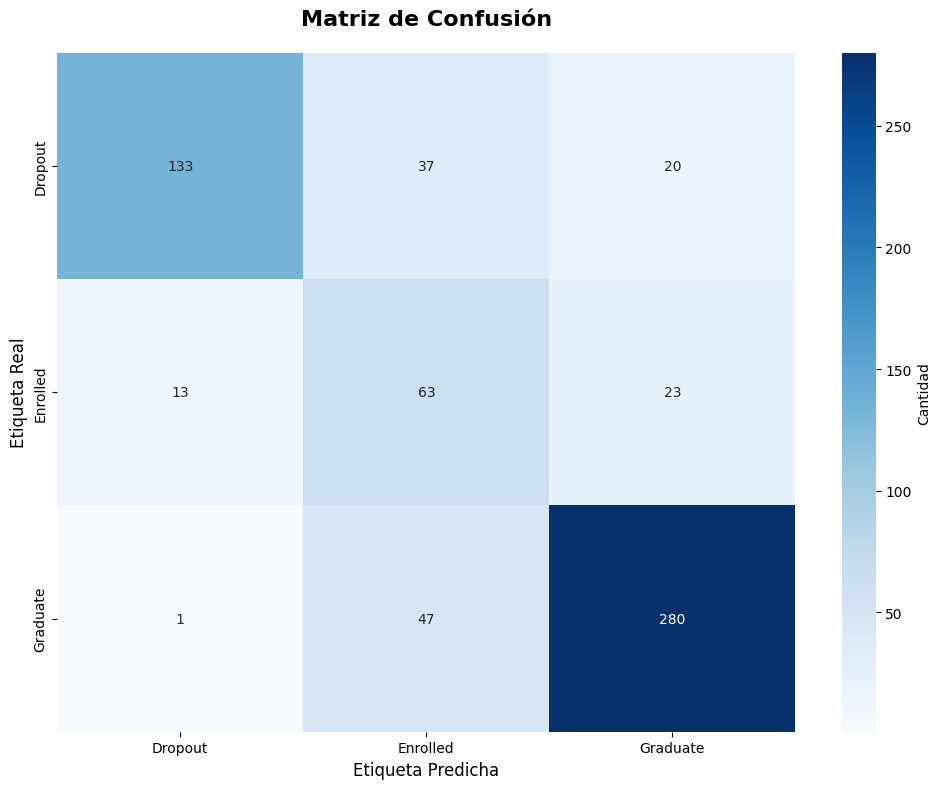


Matriz de Confusión:
               Dropout        Enrolled       Graduate       
Dropout                    133             37             20
Enrolled                    13             63             23
Graduate                     1             47            280

Métricas por Clase:

Dropout:
  Precision: 0.9048
  Recall: 0.7000
  F1-Score: 0.7893
  Soporte: 190

Enrolled:
  Precision: 0.4286
  Recall: 0.6364
  F1-Score: 0.5122
  Soporte: 99

Graduate:
  Precision: 0.8669
  Recall: 0.8537
  F1-Score: 0.8602
  Soporte: 328


In [27]:
cm = confusion_matrix(y_true, y_pred)
plt.figure(figsize=(10, 8))
sns.heatmap(cm, annot=True, fmt='d', cmap='Blues', 
            xticklabels=class_names, yticklabels=class_names,
            cbar_kws={'label': 'Cantidad'})
plt.title('Matriz de Confusión', fontsize=16, fontweight='bold', pad=20)
plt.ylabel('Etiqueta Real', fontsize=12)
plt.xlabel('Etiqueta Predicha', fontsize=12)
plt.tight_layout()
plt.show()
print("\nMatriz de Confusión:")
print("=" * 60)
print(f"{'':15}", end="")
for name in class_names:
    print(f"{name:15}", end="")
print()
for i, name in enumerate(class_names):
    print(f"{name:15}", end="")
    for j in range(len(class_names)):
        print(f"{cm[i, j]:15}", end="")
    print()
print("=" * 60)

print("\nMétricas por Clase:")
print("=" * 60)
for i, class_name in enumerate(class_names):
    tp = cm[i, i]
    fp = cm[:, i].sum() - tp
    fn = cm[i, :].sum() - tp
    tn = cm.sum() - tp - fp - fn
    
    precision_class = tp / (tp + fp) if (tp + fp) > 0 else 0
    recall_class = tp / (tp + fn) if (tp + fn) > 0 else 0
    f1_class = 2 * (precision_class * recall_class) / (precision_class + recall_class) if (precision_class + recall_class) > 0 else 0
    
    print(f"\n{class_name}:")
    print(f"  Precision: {precision_class:.4f}")
    print(f"  Recall: {recall_class:.4f}")
    print(f"  F1-Score: {f1_class:.4f}")
    print(f"  Soporte: {cm[i, :].sum()}")


**Ejemplo de aplicación del Modelo**


In [31]:
def predict_student(student_data, model, scaler, pca, class_names, device):
    model.eval()
    df = pd.DataFrame([student_data])
    
    missing_cols = set(X_train_fs.columns) - set(df.columns)
    for col in missing_cols:
        df[col] = 0
    
    df = df[X_train_fs.columns]
    df_scaled = scaler.transform(df)
    df_pc = pca.transform(df_scaled)

    with torch.no_grad():
        df_tensor = torch.FloatTensor(df_pc).to(device)
        probs = model(df_tensor)
        pred_class_idx = torch.argmax(probs, dim=1).item()
        probabilities = probs[0].cpu().numpy()
    
    return class_names[pred_class_idx], probabilities

student = {
    'curricular_units_2nd_sem_approved': 5,
    'curricular_units_1st_sem_approved': 6,
    'curricular_units_2nd_sem_grade': 12.5,
    'curricular_units_1st_sem_grade': 13.0,
    'tuition_fees_up_to_date_1': 1,
    'scholarship_holder_1': 0,
    'debtor_0': 1,
    'gender_0': 1,
    'curricular_units_2nd_sem_enrolled': 6,
    'curricular_units_1st_sem_enrolled': 6,
    'tuition_fees_up_to_date_0': 0,
    'age_at_enrollment': 20,
    'application_mode': 1,
    'scholarship_holder_0': 1,
    'debtor_1': 0,
    'gender_1': 0
}

resultado, probabilidades = predict_student(student, model, scaler, pca, class_names, device)
print(f"Predicción del estudiante: {resultado}")
print("\nProbabilidades por clase:")
for i, class_name in enumerate(class_names):
    print(f"  {class_name}: {probabilidades[i]:.4f} ({probabilidades[i]*100:.2f}%)")


Predicción del estudiante: Graduate

Probabilidades por clase:
  Dropout: 0.0001 (0.01%)
  Enrolled: 0.0417 (4.17%)
  Graduate: 0.9582 (95.82%)


c:\Users\juanp\AppData\Local\Programs\Python\Python311\Lib\site-packages\sklearn\utils\validation.py:2749: UserWarning: X does not have valid feature names, but PCA was fitted with feature names
  warnings.warn(
